## 2017 US (WWEIA) Demand Estimation and Nutritional Mapping



In [9]:
!pip install -r requirements.txt

In [10]:
US_Data = "1OWluIYUGkmR6iFgSzJJa2ikEqqMT6BHbsKZyip236HU"

In [11]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# Change 'Uganda_Data' to key of your own sheet in Sheets, above
x = read_sheets(US_Data,sheet='Food Expenditures 2017')
x["j"] = x["food_name"]
x = x.set_index(['i','t','m','j'])["grams"].squeeze()


# Now prices
#p = read_sheets(Uganda_Data,sheet='Food Prices (2019-20)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
#p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
#p = p.xs('Kg',level="u").squeeze().unstack('j')

# Drop prices for goods we don't have expenditures for
#p = p[x.index.levels[-1]].T

# Household characteristics
d = read_sheets(US_Data,sheet="Household Characteristics 2017")
d.columns.name = 'k'
d["sex"] = d["sex"].map({"Female": 1, "Male": 0})
d['log_household'] = np.log(d['HH_size'])
d.drop("HH_size", axis= 1, inplace=True)

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)
d.set_index(['i','t','m'],inplace=True)


In [109]:
x.shape

(90069,)

In [110]:
x.unstack("j")

,,j,3 musketeers bar,Agave liquid sweetener,"Air filled fritter or fried puff, without syrup, puerto rica",Alcoholic malt beverage,"Alcoholic malt beverage, sweetened",Alexander,"Alfalfa sprouts, raw",Alfredo sauce,Almond butter,"Almond butter, lower sodium",...,"Yogurt, ns as to type of milk, flavors other than fruit","Yogurt, ns as to type of milk, fruit","Yogurt, ns as to type of milk, plain","Yogurt, whole milk, baby food","Yogurt, whole milk, baby food, with fruit and multigrain cer","Yogurt, whole milk, flavors other than fruit","Yogurt, whole milk, fruit","Yogurt, whole milk, plain",Yuca fries,Zwieback toast
i,t,m,,,,,,,,,,,,,,,,,,,,,
93704,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705,2017,USA,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93706,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93707,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93708,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99145,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99146,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99149,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
y.head()

i      t     m    j                                        
93704  2017  USA  Apple juice, 100%                            5.448890
                  Applesauce, flavored                         4.730921
                  Asparagus, fresh, cooked, no added fat       2.420368
                  Cereal (general mills cheerios honey nut)    3.323236
                  Cheese, mozzarella, part skim                3.344627
Name: grams, dtype: float64

### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### Basic Estimation



Just one line to set up the regression:



In [112]:
y

i      t     m    j                                              
93704  2017  USA  Apple juice, 100%                                  5.448890
                  Applesauce, flavored                               4.730921
                  Asparagus, fresh, cooked, no added fat             2.420368
                  Cereal (general mills cheerios honey nut)          3.323236
                  Cheese, mozzarella, part skim                      3.344627
                                                                       ...   
99152  2017  USA  Roll, white, soft                                  3.761200
                  Swiss steak                                        5.135798
                  Thuringer                                          5.620401
                  Vegetable beef soup, canned, prepared with milk    5.544200
                  Vegetable beef soup, home recipe                   5.515604
Name: grams, Length: 90069, dtype: float64

In [113]:
d

,,k,age,sex,log_household
i,t,m,,,
93703,2017,USA,2.0,1,1.609438
93704,2017,USA,2.0,0,1.386294
93705,2017,USA,66.0,1,0.000000
93706,2017,USA,18.0,0,1.609438
93707,2017,USA,13.0,0,1.945910
...,...,...,...,...,...
102952,2017,USA,70.0,1,0.693147
102953,2017,USA,42.0,0,0.000000
102954,2017,USA,41.0,1,1.945910


In [12]:

food_counts = y.groupby('j').count()
top_foods = food_counts.sort_values(ascending=False).head(1000).index
x_filtered = x[x.index.get_level_values('j').isin(top_foods)]
y_filtered = y[y.index.get_level_values('j').isin(top_foods)] #used the top 350 foods to prevent regression issues

# Step 3.2: Random sample of 500 households
sample_ids = y_filtered.index.get_level_values('i').unique().to_series().sample(1750, random_state=42)

# Sample dataframes used for testing purposes only 
# Filter y and d to match
y_sample = y_filtered[y_filtered.index.get_level_values('i').isin(sample_ids)]
d_sample = d[d.index.get_level_values('i').isin(sample_ids)]

# Final checks
print("Shape of y_sample:", y_sample.shape)
print("Shape of d_sample:", d_sample.shape)

Shape of y_sample: (29057,)
Shape of d_sample: (1750, 3)


In [115]:
d

,,k,age,sex,log_household
i,t,m,,,
93703,2017,USA,2.0,1,1.609438
93704,2017,USA,2.0,0,1.386294
93705,2017,USA,66.0,1,0.000000
93706,2017,USA,18.0,0,1.609438
93707,2017,USA,13.0,0,1.945910
...,...,...,...,...,...
102952,2017,USA,70.0,1,0.693147
102953,2017,USA,42.0,0,0.000000
102954,2017,USA,41.0,1,1.945910


In [116]:
y.unstack("j")

,,j,3 musketeers bar,Agave liquid sweetener,"Air filled fritter or fried puff, without syrup, puerto rica",Alcoholic malt beverage,"Alcoholic malt beverage, sweetened",Alexander,"Alfalfa sprouts, raw",Alfredo sauce,Almond butter,"Almond butter, lower sodium",...,"Yogurt, ns as to type of milk, flavors other than fruit","Yogurt, ns as to type of milk, fruit","Yogurt, ns as to type of milk, plain","Yogurt, whole milk, baby food","Yogurt, whole milk, baby food, with fruit and multigrain cer","Yogurt, whole milk, flavors other than fruit","Yogurt, whole milk, fruit","Yogurt, whole milk, plain",Yuca fries,Zwieback toast
i,t,m,,,,,,,,,,,,,,,,,,,,,
93704,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705,2017,USA,3.931826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93706,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93707,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93708,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99145,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99146,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99149,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


this regression can take up to 10 mins to load:

In [132]:
from cfe import Regression

result = Regression(y=y_filtered, d=d, min_obs = 10, min_prop_items= 0.002) 

And then one line to predict expenditures and estimate most of the things we need:



In [133]:
result.predicted_expenditures()

i      t     m    j                                         
93704  2017  USA  Apple, raw                                      59.963947
                  Banana, raw                                     70.603380
                  Barbecue sauce                                   2.397317
                  Beer                                           618.053328
                  Bread, wheat or cracked wheat                   23.193809
                                                                   ...     
99152  2017  USA  Tomatoes, for use on a sandwich                 21.944862
                  Tomatoes, raw                                  115.035220
                  Turkey, prepackaged or deli, luncheon meat      91.915135
                  Water, bottled, unsweetened                   1539.091322
                  Water, tap                                    1662.586026
Length: 223074, dtype: float64

### Predicted log expenditures vs actual:



<Axes: xlabel='yhat', ylabel='y'>

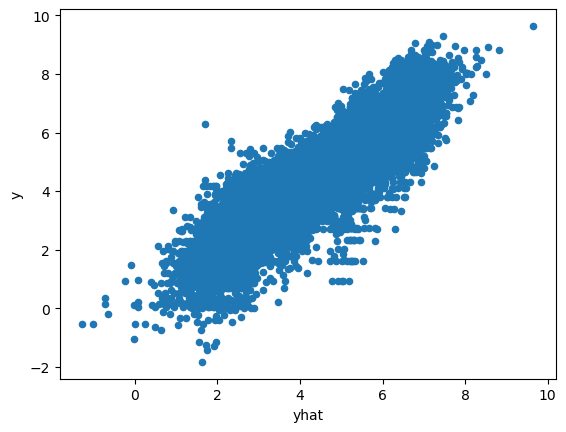

In [134]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

#### Parameters



##### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.
Here we use a plot to visualize, with confidence intervals.



Can't compute covariance matrix; too few Italian dressing, made with vinegar and oil.


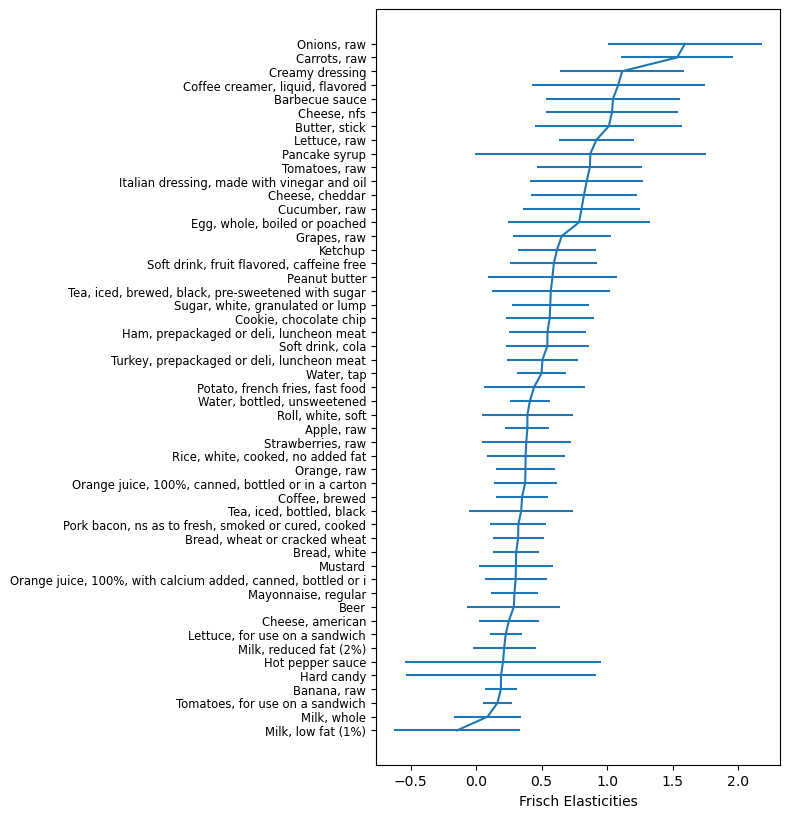

In [135]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [85]:
beta = result.get_beta()

beta.to_csv("betas_2017.csv")

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [84]:
gamma = result.get_gamma()
gamma.to_csv("gammas_2017.csv")

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

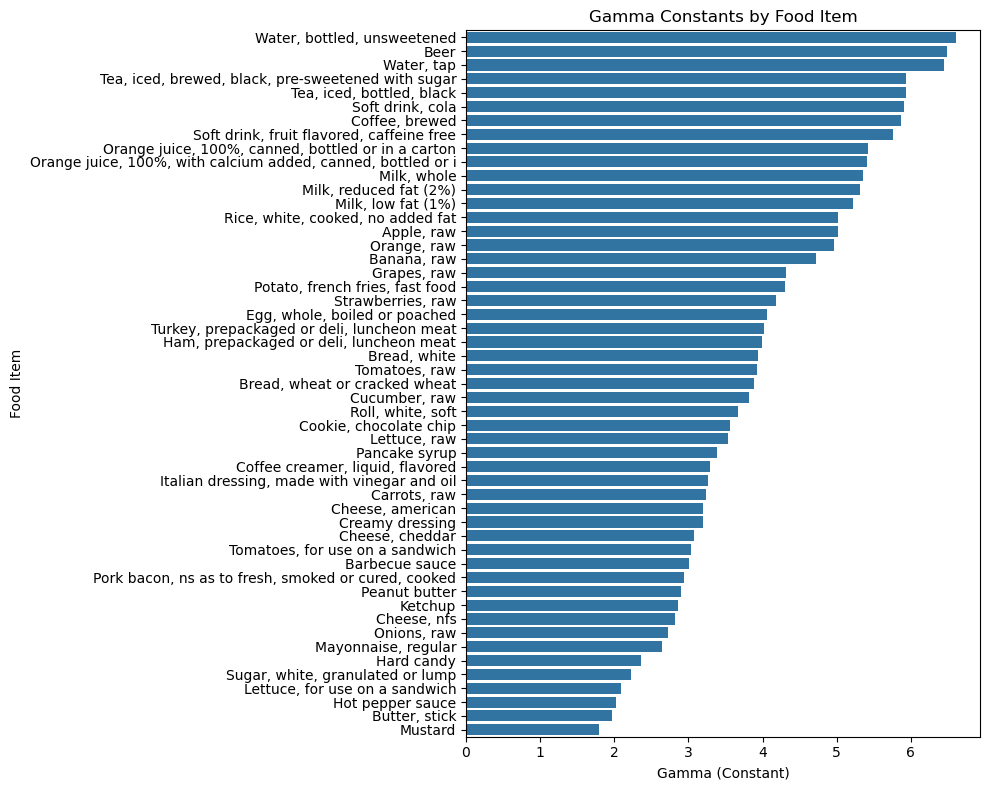

In [139]:
gamma = result.get_gamma()
gamma_sorted = gamma.sort_values(by="Constant", ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(data=gamma_sorted, x="Constant", y="j")
plt.xlabel("Gamma (Constant)")
plt.ylabel("Food Item")
plt.title("Gamma Constants by Food Item")
plt.tight_layout()
plt.show()

In [83]:
gamma = result.get_gamma()
gamma[["Constant"]].sort_values("Constant")

##### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



<Axes: ylabel='Density'>

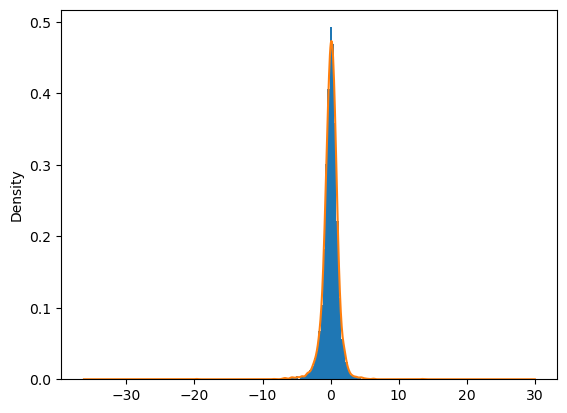

In [6]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

In [7]:
result.get_w()[(result.get_w() > -10) & (result.get_w() < 10)]

i      t     m  
93704  2017  USA   -2.584007
93705  2017  USA   -0.980743
93706  2017  USA    0.103385
93707  2017  USA   -0.277043
93708  2017  USA   -1.104833
                      ...   
99145  2017  USA    0.390977
99146  2017  USA   -2.095100
99149  2017  USA   -0.344774
99151  2017  USA   -0.402770
99152  2017  USA    0.575991
Length: 4348, dtype: float64

<Axes: ylabel='Density'>

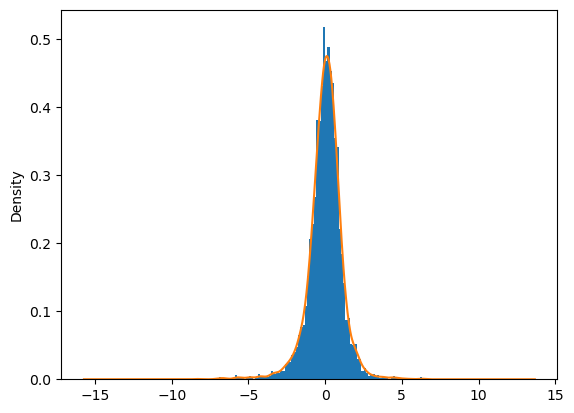

In [8]:
ax = result.get_w()[(result.get_w() > -10) & (result.get_w() < 10)].plot.hist(bins=100,density=True)
result.get_w()[(result.get_w() > -10) & (result.get_w() < 10)].plot.kde(ax=ax)

#### Saving Result



In [144]:
result.to_pickle('us_estimates_2017.rgsn')

In [13]:
import cfe
result = cfe.regression.read_pickle('us_estimates_2017.rgsn')

#### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



##### Budgets



Get food budget for all households, then find median budget:



In [14]:
p = pd.read_csv("proj3_min_cost_data - prices.csv")

# data cleaning to match 

p["u"] = "Kg"
p["m"] = "USA"
p["price"] = p["price"] * 10
p = p[p["t"] == "2017/2018"]

codes = pd.read_csv("proj3_min_cost_data - recipes.csv")

codes = codes[["parent_foodcode", "parent_desc"]]
c = codes.groupby("parent_foodcode").first()
c.rename(columns = {"parent_foodcode": "j"})
p = p.join(c, on="j") 
p = p.drop("j", axis=1)
p = p.rename(columns = {"parent_desc":"j"})
p = p.set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')


# Identify the common keys between x_filtered.index.levels[-1] and p.columns
common_keys = p.columns.intersection(x_filtered.index.levels[-1])

# Now subset p with these keys and transpose the result.
p = p[common_keys].T


In [15]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

In [16]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
#pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

common_keys = pbar.index.intersection(result.beta.index)
pbar = pbar.loc[common_keys]
pbar = pbar.replace(np.nan, 1)

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

common_keys

Index(['Apple, raw', 'Banana, raw', 'Barbecue sauce', 'Beer',
       'Bread, wheat or cracked wheat', 'Bread, white', 'Butter, stick',
       'Carrots, raw', 'Coffee creamer, liquid, flavored', 'Coffee, brewed',
       'Cookie, chocolate chip', 'Creamy dressing', 'Cucumber, raw',
       'Egg, whole, boiled or poached', 'Grapes, raw',
       'Ham, prepackaged or deli, luncheon meat', 'Hard candy',
       'Hot pepper sauce', 'Italian dressing, made with vinegar and oil',
       'Ketchup', 'Lettuce, for use on a sandwich', 'Lettuce, raw',
       'Mayonnaise, regular', 'Milk, low fat (1%)', 'Milk, reduced fat (2%)',
       'Milk, whole', 'Mustard', 'Onions, raw',
       'Orange juice, 100%, canned, bottled or in a carton', 'Orange, raw',
       'Pancake syrup', 'Peanut butter', 'Potato, french fries, fast food',
       'Rice, white, cooked, no added fat', 'Roll, white, soft',
       'Soft drink, cola', 'Soft drink, fruit flavored, caffeine free',
       'Strawberries, raw', 'Sugar, white, 

##### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets. Here are the demand curves for french fries.



In [17]:
import warnings

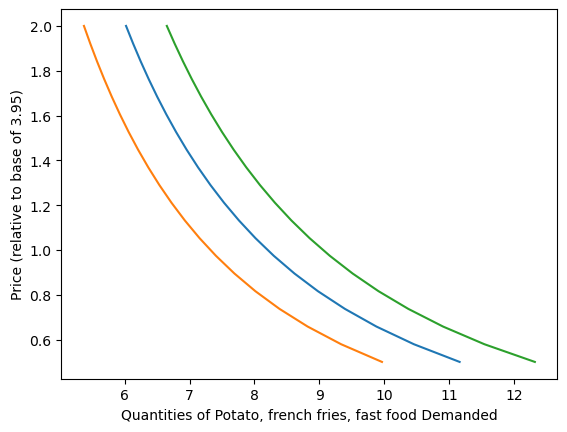

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Potato, french fries, fast food'  # Good we want demand curve for
pbar = pbar.reindex(result.beta.index).fillna(1)
# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

warnings.filterwarnings("ignore")

In [19]:
def plot_demand_curves(goods):
    """
    Plot demand curves for multiple goods over a range of price scales.
    
    Parameters
    ----------
    goods : tuple or list of str
        The food identifiers (common keys) for which you want to plot demand curves.
        For example: ('Banana, raw', 'Apple, raw', 'Milk, whole')
    
    Global variables required:
      - pbar: pd.Series with reference prices (indexed by food identifiers)
      - result: an object with methods demands() and attribute beta.index
      - xref: reference expenditure vector (e.g., median expenditures)
      - xbar: household total expenditures (used for quantile calculations)
      - my_prices(): function to adjust the price vector
    """
    # Suppress specific warnings (from consumerdemands._utils)
    warnings.filterwarnings("ignore", message="Setting negative values of beta to zero")
    
    # Ensure pbar covers all keys in result.beta.index; fill missing values with 1.
    pbar_local = pbar.reindex(result.beta.index, fill_value=1)
    
    # Define a range of scale factors to vary the price from 50% to 200% of reference.
    scale = np.linspace(0.5, 2, 20)
    
    # Create a new figure for the plot.
    plt.figure(figsize=(10, 8))
    
    # Loop over each good in the input tuple/list.
    for good in goods:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Setting negative values of beta to zero")
            # Compute the demand for the given good at various price levels.
            median_demand = [result.demands(xref, my_prices(pbar_local[good] * s, good, pbar_local))[good]
                             for s in scale]
            demand_q25 = [result.demands(xbar.quantile(0.25), my_prices(pbar_local[good] * s, good, pbar_local))[good]
                          for s in scale]
            demand_q75 = [result.demands(xbar.quantile(0.75), my_prices(pbar_local[good] * s, good, pbar_local))[good]
                          for s in scale]
        
        # Plot each demand curve with distinct line styles and markers.
        plt.plot(median_demand, scale,
                 label=f"{good} (Median Budget)")
        plt.plot(demand_q25, scale,
                 label=f"{good} (25th Percentile Budget)")
        plt.plot(demand_q75, scale,
                 label=f"{good} (75th Percentile Budget)")
    
    # Add labels, title, legend, and grid.
    plt.xlabel("Quantity Demanded")
    # This label uses the base reference price of the first good in the list for display.
    plt.ylabel(f"Price (relative to base of {pbar_local[goods[0]]:.2f})")
    plt.title("Demand Curves for Selected Goods")
    plt.legend()
    plt.grid(True)
    plt.show()

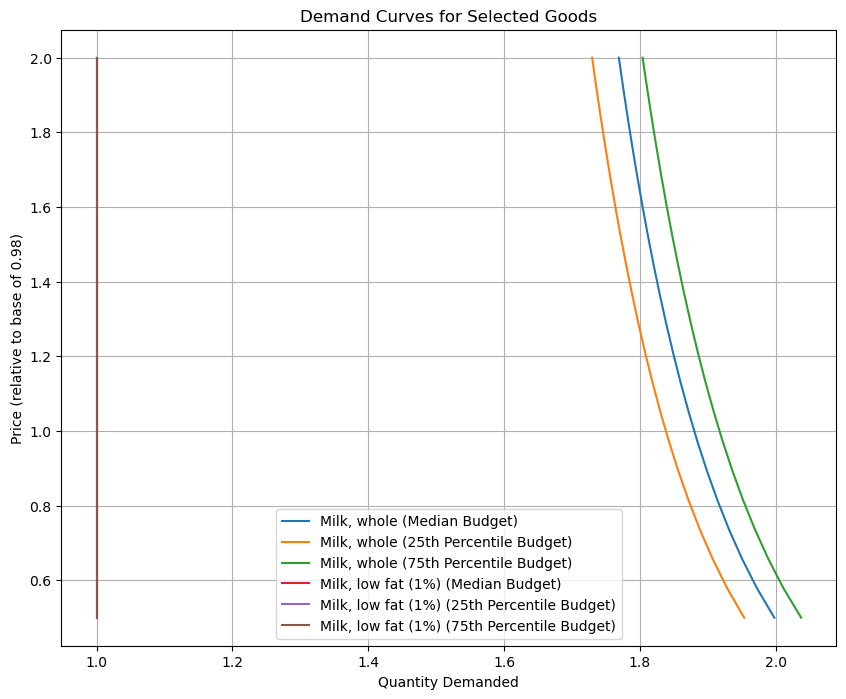

In [20]:
plot_demand_curves(('Milk, whole', 'Milk, low fat (1%)'))

##### Engel Curves



Engel curves trace out how demand changes with budget:



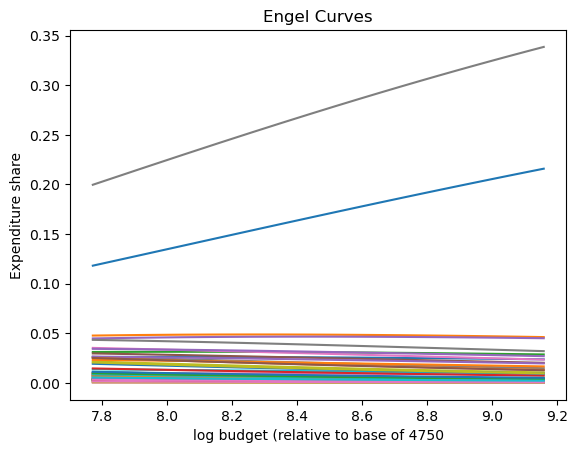

In [21]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

warnings.filterwarnings("ignore")

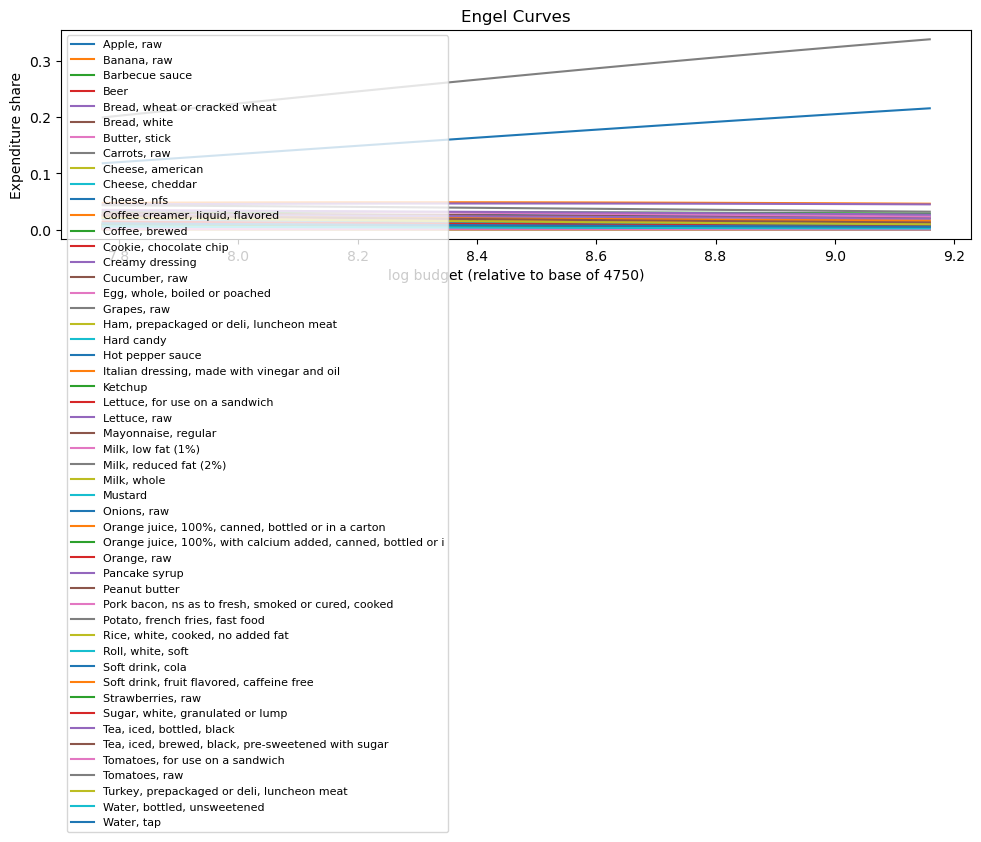

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create a range of budgets by scaling the base budget xref.
scale = np.linspace(0.5, 2, 20)

# Loop over each good in pbar.
for good in pbar.index:
    shares = []
    for s in scale:
        budget = s * xref  # Adjust budget by the scale factor.
        # Compute expenditures for all goods at this budget.
        exp_series = result.expenditures(budget, pbar)
        # Compute the expenditure share for the current good.
        share = exp_series[good] / budget
        shares.append(share)
    # Plot the Engel curve for the current good,
    # using the log-budget (log(scale * xref)) on the x-axis.
    ax.plot(np.log(scale * xref), shares, label=good)

ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel('Expenditure share')
ax.set_title('Engel Curves')

# Add a legend to label each curve with the good’s name.
ax.legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()

warnings.filterwarnings("ignore")

### Engel curves for selected foods with a large share of expenditure

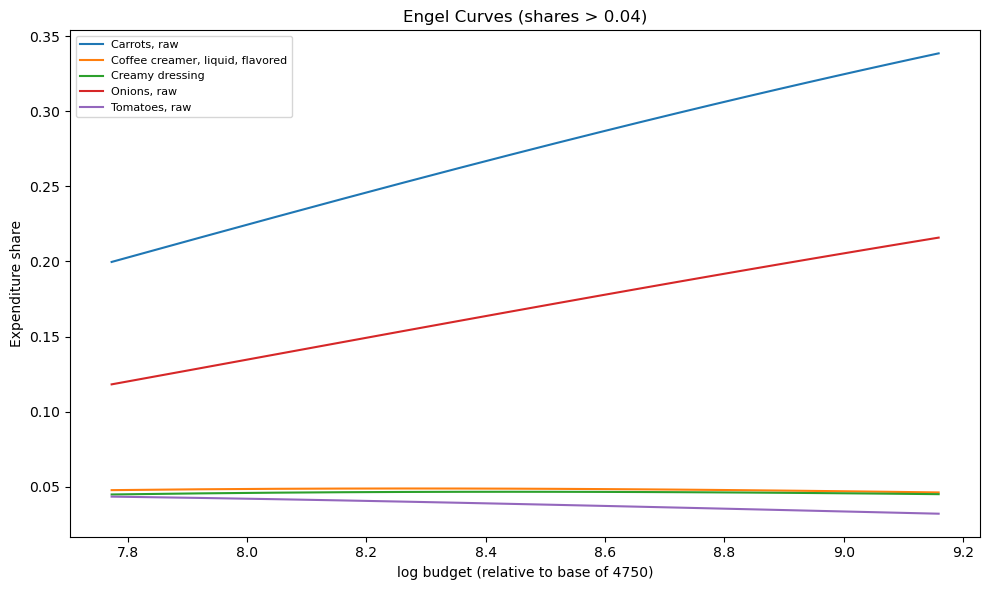

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

# Define a range of multipliers to vary the base budget.
scale = np.linspace(0.5, 2, 20)

# Loop over each good in pbar (which is assumed to be a Series indexed by good names).
for good in pbar.index:
    shares = []
    # Compute the expenditure share for each scaled budget.
    for s in scale:
        budget = s * xref  # Adjust the base budget.
        exp_series = result.expenditures(budget, pbar)
        share = exp_series[good] / budget
        shares.append(share)
    # Filter: plot only if the maximum share exceeds 0.04.
    if max(shares) > 0.04:
        ax.plot(np.log(scale * xref), shares, label=good)

ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel('Expenditure share')
ax.set_title('Engel Curves (shares > 0.04)')
ax.legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()
warnings.filterwarnings("ignore")

##### Indirect Utility



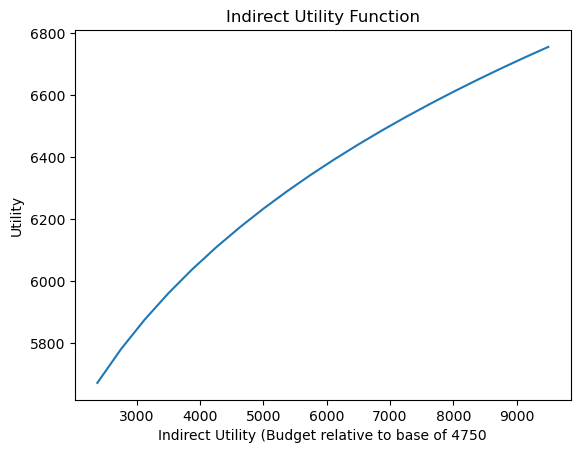

In [22]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')

# Suppress specific warnings (from consumerdemands._utils)
warnings.filterwarnings("ignore")

# Nutrition Data




In [23]:
xhat.unstack('j')

,,j,"Apple, raw","Banana, raw",Barbecue sauce,Beer,"Bread, wheat or cracked wheat","Bread, white","Butter, stick","Carrots, raw","Cheese, american","Cheese, cheddar",...,"Soft drink, fruit flavored, caffeine free","Strawberries, raw","Sugar, white, granulated or lump","Tea, iced, bottled, black","Tea, iced, brewed, black, pre-sweetened with sugar","Tomatoes, for use on a sandwich","Tomatoes, raw","Turkey, prepackaged or deli, luncheon meat","Water, bottled, unsweetened","Water, tap"
i,t,m,,,,,,,,,,,,,,,,,,,,,
93704,2017,USA,59.938080,70.248079,NaN,NaN,NaN,26.673297,NaN,0.852300,12.454352,NaN,...,70.941322,NaN,2.476011,NaN,NaN,14.516990,5.836703,NaN,255.348408,188.510633
93705,2017,USA,110.083569,96.152378,NaN,NaN,NaN,39.441573,NaN,5.082479,21.196020,NaN,...,226.978034,NaN,7.513806,NaN,NaN,16.872397,29.030033,NaN,812.740022,805.759355
93706,2017,USA,181.038702,122.790328,NaN,NaN,NaN,59.566120,NaN,43.975586,26.933440,NaN,...,372.511226,NaN,11.989994,NaN,NaN,23.036344,64.244225,NaN,915.352172,801.480937
93707,2017,USA,154.483043,113.835703,NaN,NaN,NaN,52.573157,NaN,24.872690,24.375159,NaN,...,282.813218,NaN,9.420465,NaN,NaN,21.545810,45.168440,NaN,756.269852,613.318888
93708,2017,USA,106.096179,95.793518,NaN,NaN,NaN,37.043399,NaN,3.905561,21.472824,NaN,...,200.372332,NaN,6.901187,NaN,NaN,16.597831,25.980924,NaN,797.910178,701.536014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99145,2017,USA,194.731675,125.646952,NaN,NaN,NaN,65.287711,NaN,77.060226,27.255450,NaN,...,406.595584,NaN,13.351695,NaN,NaN,23.730326,77.867414,NaN,902.690398,810.031409
99146,2017,USA,72.589745,77.078071,NaN,NaN,NaN,30.981356,NaN,1.805250,14.081278,NaN,...,94.826794,NaN,3.266646,NaN,NaN,15.725392,8.925539,NaN,312.219851,240.675826
99149,2017,USA,120.366245,97.190949,NaN,NaN,NaN,46.797463,NaN,20.518324,20.362032,NaN,...,209.623515,NaN,8.197693,NaN,NaN,17.425083,38.736984,NaN,613.998635,537.230507


In [24]:
p

t,2017/2018
m,USA
j,
Agave liquid sweetener,8.52492
"Alcoholic malt beverage, sweetened",3.76661
"Alfalfa sprouts, raw",16.21247
Alfredo sauce,5.03620
Almond butter,17.66285
...,...
"Yogurt, nonfat milk, plain",4.12198
"Yogurt, whole milk, baby food",5.95216


In [25]:
p_new = pd.read_csv("proj3_min_cost_data - prices.csv")
p_new["u"] = "Kg"

p_new["m"] = "USA"

p_new["price"] = p_new["price"] * 10

p_new = p_new[p_new["t"] == "2017/2018"]


p_new = p_new.join(c, on="j") 
p_new = p_new.drop("j", axis=1)
p_new = p_new.drop("t", axis=1)
p_new = p_new.drop("u", axis=1)
p_new = p_new.rename(columns = {"parent_desc":"j"})

p_new

,m,price,j
10577,USA,1.00484,"Milk, NFS"
10578,USA,0.98280,"Milk, whole"
10579,USA,0.92085,"Milk, reduced fat (2%)"
10580,USA,0.90914,"Milk, low fat (1%)"
10581,USA,0.92441,"Milk, fat free (skim)"
...,...,...,...
15007,USA,1.20958,Sports drink (Gatorade G)
15008,USA,0.91942,Sports drink (Powerade)
15009,USA,1.14084,"Sports drink, low calorie (Gatorade G2)"
15010,USA,0.89002,"Sports drink, low calorie (Powerade Zero)"


In [26]:
p_pivot = p_new.pivot_table(
    index=["m"],   # or ["m", "t"] if you prefer that order
    columns="j",
    values="price",
    aggfunc="sum"      # or another aggregation if you have duplicates
)

p_pivot

j,100 GRAND Bar,3 MUSKETEERS Bar,"Adobo, with noodles","Adobo, with rice",Agave liquid sweetener,"Alcoholic malt beverage, sweetened","Alfalfa sprouts, raw",Alfredo sauce,Almond butter,"Almond milk, sweetened",...,"Yogurt, low fat milk, plain","Yogurt, nonfat milk, flavors other than fruit","Yogurt, nonfat milk, fruit","Yogurt, nonfat milk, plain","Yogurt, soy","Yogurt, whole milk, baby food","Yogurt, whole milk, flavors other than fruit","Yogurt, whole milk, fruit","Yogurt, whole milk, plain","Zucchini soup, cream of, prepared with milk"
m,,,,,,,,,,,,,,,,,,,,,
USA,10.2129,12.5797,6.74801,6.38532,8.52492,3.76661,16.21247,5.0362,17.66285,1.69743,...,4.12198,5.28725,4.35241,4.12198,9.19396,5.95216,5.28725,4.35241,4.12198,2.44685


In [27]:
# Expenditures divided by prices/kg gives quantities in kgs...
xhat_unstacked = xhat.unstack('j')
xhat_unstacked_aligned = xhat_unstacked.reindex(index=p_pivot.index, columns=p_pivot.columns)
common_columns = xhat_unstacked_aligned.columns.intersection(p_pivot.columns)
common_index = xhat_unstacked_aligned.index.intersection(p_pivot.index)

p_pivot_aligned = p_pivot.loc[common_index, common_columns]

qhat = (xhat_unstacked/p_pivot_aligned).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

In [28]:
nutrients = pd.read_csv("proj3_min_cost_data - nutrients.csv")
recipes = pd.read_csv("proj3_min_cost_data - recipes.csv")

# from fndds diet problem: normalize weights to percentage terms. 
recipes['ingred_wt'] = recipes['ingred_wt']/recipes.groupby(['parent_foodcode'])['ingred_wt'].transform("sum")

# we're going to extend the recipes data frame to include the nutrient profiles of its ingredients (in 100g)
df = recipes.merge(nutrients, how="left", on="ingred_code")

# multiply all nutrients per 100g of an ingredient by the weight of that ingredient in a recipe.
numeric_cols = list(df.select_dtypes(include=["number"]).columns)
numeric_cols.remove("ingred_wt")
df[numeric_cols] = df[numeric_cols].mul(df["ingred_wt"], axis=0)
df = df.rename(columns={'parent_desc': 'j'})

# sum nutrients of food codes (over the multiple ingredients)
# python tip: one can merge dictionaries dict1 dict2 using **, that is: dict_merge = {**dict1, **dict2}. 
#The ** effectively "unpacks" the key value pairs in each dictionary
df = df.groupby('j').agg({**{col: "sum" for col in numeric_cols},
                                        "j": "first"})
df.drop("parent_foodcode", axis = 1, inplace=True)
df.drop("ingred_code", axis = 1, inplace=True)
df.drop("j", axis = 1, inplace=True)

df.index.name = "j"

fct = df


In [29]:
fct.index

Index(['100 GRAND Bar', '3 MUSKETEERS Bar', '3 Musketeers Truffle Crisp Bar',
       'Abalone, cooked, NS as to cooking method',
       'Abalone, floured or breaded, fried', 'Abalone, steamed or poached',
       'Adobo, with noodles', 'Adobo, with rice', 'Agave liquid sweetener',
       'Air filled fritter or fried puff, without syrup, Puerto Rican style',
       ...
       'Yogurt, whole milk, plain', 'Yokan', 'Youngberries, raw', 'Yuca fries',
       'Zabaglione', 'Zombie', 'Zucchini lasagna, diet frozen meal',
       'Zucchini soup, cream of, prepared with milk', 'Zucchini, pickled',
       'Zwieback toast'],
      dtype='object', name='j', length=8886)

In [30]:
qhat.columns

Index(['Apple, raw', 'Banana, raw', 'Bread, white', 'Carrots, raw',
       'Coffee, brewed', 'Cookie, chocolate chip', 'Creamy dressing',
       'Cucumber, raw', 'Grapes, raw', 'Ketchup',
       'Lettuce, for use on a sandwich', 'Lettuce, raw', 'Mayonnaise, regular',
       'Milk, reduced fat (2%)', 'Milk, whole', 'Mustard',
       'Potato, french fries, fast food', 'Soft drink, cola',
       'Soft drink, fruit flavored, caffeine free',
       'Sugar, white, granulated or lump', 'Tomatoes, for use on a sandwich',
       'Tomatoes, raw', 'Water, bottled, unsweetened', 'Water, tap'],
      dtype='object', name='j')

## Map predicted quantities into nutrients


In [31]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

Capric acid         2.007733e+02
Lauric acid         9.751886e+01
Myristic acid       4.433601e+02
Palmitic acid       1.249265e+05
Palmitoleic acid    6.165807e+03
                        ...     
Vitamin E           1.956850e+06
Vitamin E, added    0.000000e+00
Vitamin K           3.960248e+07
Water               2.616201e+08
Zinc                7.091313e+05
Length: 65, dtype: float64

In [32]:
rdi = pd.read_csv("proj3_min_cost_data - rda_new.csv")
rdi["n"] = rdi["Nutrient"]
rdi.drop("Nutrient", axis = 1, inplace=True)
rdi.drop("Nutrient Type", axis = 1, inplace=True)
rdi.drop("Unit", axis = 1, inplace=True)
rdi.drop("Constraint Type", axis = 1, inplace=True)
rdi = rdi.set_index("n")

In [33]:
d = read_sheets(US_Data,sheet="Household Characteristics 2017")
d.columns.name = 'k'
d = d.replace(np.nan,0)

In [34]:
# Define age bins and labels
bins = [0, 4, 9, 14, 19, 31, 51, 100]
labels = ['00-03', '04-08', '09-13', '14-18', '19-30', '31-50', '51-99']

# Assign age group based on bins
d['age_group'] = pd.cut(d['age'], bins=bins, labels=labels, right=False)

# Create column name like "Females 00-03", "Males 14-18", etc.
d['group'] = d['sex'] + 's ' + d['age_group'].astype(str)

# Count each person as 1
d['count'] = 1

# Pivot the table to wide format: rows = (i, t, m), columns = group
df_grouped = d.pivot_table(index=['i', 't', 'm'], columns='group', values='count',  aggfunc='sum', fill_value=0)

# Flatten the column index
df_grouped.columns.name = None
df_grouped = df_grouped.reset_index()

# Add log household size
df_hsize = d.drop_duplicates(['i', 't', 'm'])[['i', 't', 'm', 'HH_size']]
df_hsize['log HSize'] = np.log(df_hsize['HH_size'])

# Merge back
final_d = pd.merge(df_grouped, df_hsize.drop(columns='HH_size'), on=['i', 't', 'm'])

final_d.set_index(['i','t','m'],inplace=True)
final_d.head()

,,,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,
93703,2017,USA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.609438
93704,2017,USA,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.386294
93705,2017,USA,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
93706,2017,USA,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.609438
93707,2017,USA,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.945910


In [65]:
final_d = final_d[rdi.columns.tolist()]

hh_rdi = final_d@rdi.T
hh_rwi = hh_rdi * 7
hh_rdi

,,n,Energy,Protein,Carbohydrate,Dietary Fiber,Linoleic Acid,Linolenic Acid,Calcium,Iron,Magnesium,Phosphorus,...,Vitamin D,Vitamin C,Thiamin,Riboflavin,Niacin,Vitamin B6,Vitamin B12,Choline,Vitamin K,Folate
i,t,m,,,,,,,,,,,,,,,,,,,,,
93703,2017,USA,1000.0,13.0,130.0,14.0,7.0,0.7,700.0,7.0,80.0,460.0,...,15.0,15.0,0.5,0.5,6.0,0.5,0.9,200.0,30.0,150.0
93704,2017,USA,1000.0,13.0,130.0,14.0,7.0,0.7,700.0,7.0,80.0,460.0,...,15.0,15.0,0.5,0.5,6.0,0.5,0.9,200.0,30.0,150.0
93705,2017,USA,1600.0,46.0,130.0,22.4,11.0,1.1,1200.0,8.0,320.0,700.0,...,15.0,75.0,1.1,1.1,14.0,1.5,2.4,425.0,90.0,400.0
93706,2017,USA,2200.0,52.0,130.0,30.8,16.0,1.6,1300.0,11.0,410.0,1250.0,...,15.0,75.0,1.2,1.3,16.0,1.3,2.4,550.0,75.0,400.0
93707,2017,USA,1800.0,34.0,130.0,25.2,12.0,1.2,1300.0,8.0,240.0,1250.0,...,15.0,45.0,0.9,0.9,12.0,1.0,1.8,375.0,60.0,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952,2017,USA,1600.0,46.0,130.0,22.4,11.0,1.1,1200.0,8.0,320.0,700.0,...,15.0,75.0,1.1,1.1,14.0,1.5,2.4,425.0,90.0,400.0
102953,2017,USA,2200.0,56.0,130.0,30.8,17.0,1.6,1000.0,8.0,420.0,700.0,...,15.0,90.0,1.2,1.3,16.0,1.3,2.4,550.0,120.0,400.0
102954,2017,USA,1800.0,46.0,130.0,25.2,12.0,1.1,1000.0,18.0,320.0,700.0,...,15.0,75.0,1.1,1.1,14.0,1.3,2.4,425.0,90.0,400.0


In [66]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

nutrient_ratio

,,,Linoleic Acid,Linolenic Acid,Calcium,Carbohydrate,Choline,Copper,Energy,Dietary Fiber,Folate,Iron,...,Sodium,Thiamin,Vitamin A,Vitamin B12,Vitamin B6,Vitamin C,Vitamin D,Vitamin E,Vitamin K,Zinc
i,t,m,,,,,,,,,,,,,,,,,,,,,
93704,2017,USA,3.674360,8.625908,15.319926,7.216400,7.277484,11.503572,7.125524,1.990036,5.148875,1.696802,...,3.675808,10.127389,13.500763,42.272179,11.219268,5.324821,6.586444,1.579804,4.297211,12.918188
93705,2017,USA,3.768572,6.486960,9.224398,11.796722,3.108597,9.479924,5.621572,2.099197,2.353209,2.679523,...,3.256260,4.925672,4.504754,10.718682,4.184386,1.736605,4.418043,0.929326,3.308204,4.576033
93706,2017,USA,5.082091,8.510696,13.436960,20.344963,4.236369,12.199268,7.222591,2.523655,3.874266,3.262784,...,5.404872,7.507267,8.322323,20.548544,7.930145,2.921163,8.309205,1.734855,8.892696,5.903692
93707,2017,USA,5.310598,9.250725,12.121193,16.814475,5.590308,12.770594,7.496256,2.575796,4.471337,3.664232,...,4.750990,8.831807,10.453119,25.903269,9.171668,4.049267,7.884144,1.918060,8.079545,7.254959
93708,2017,USA,3.383912,5.799349,8.554221,10.868533,2.815421,8.719260,5.148526,2.015991,2.157931,2.455051,...,2.957245,4.456774,4.056440,9.757434,3.979083,1.669303,4.016571,0.849620,2.908035,4.157072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99145,2017,USA,9.438983,17.635167,19.344902,22.451283,10.536782,26.043387,12.688299,4.465974,8.675524,3.996286,...,7.362030,16.814626,24.250288,47.333811,19.123028,9.916408,9.559178,4.300891,14.778494,14.684616
99146,2017,USA,4.347905,9.663092,16.796018,8.494594,7.977294,13.450771,8.092128,2.320767,5.781234,2.023188,...,4.176694,11.237926,14.719223,45.448675,12.412899,6.146688,7.053861,1.830563,5.453940,14.228927
99149,2017,USA,6.764137,12.543534,18.677988,12.924999,8.454230,21.897206,10.593491,3.731321,7.267071,3.329522,...,5.605172,12.959150,17.252154,42.992458,15.041916,9.883858,6.632143,2.728228,12.174416,15.596499


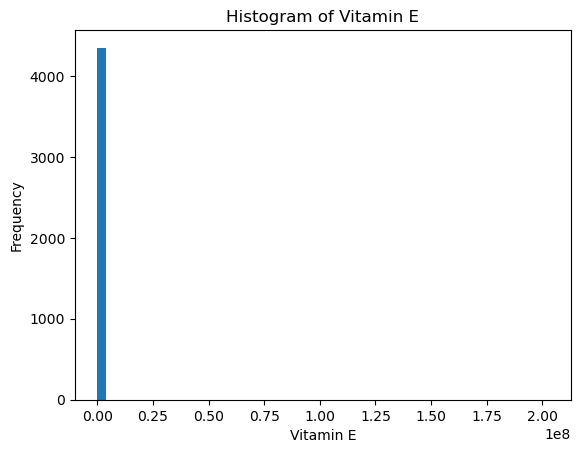

In [67]:
%matplotlib inline
plt.hist(nutrient_ratio['Vitamin E'].values, bins=50)
plt.xlabel("Vitamin E")
plt.ylabel("Frequency")
plt.title("Histogram of Vitamin E")
plt.show()

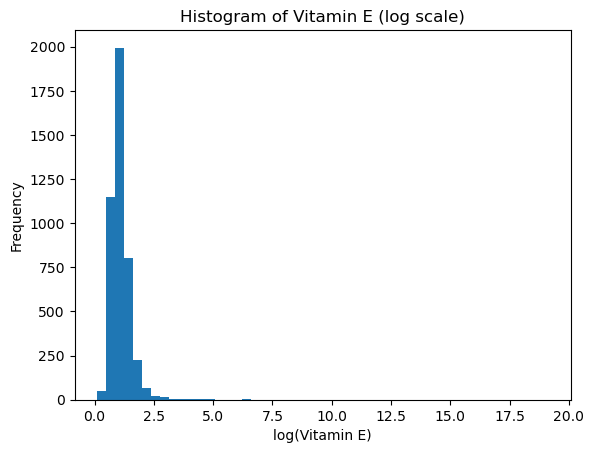

In [68]:
import numpy as np
log_values = np.log(nutrient_ratio["Vitamin E"].values + 1)  # +1 to avoid log(0)
plt.hist(log_values, bins=50)
plt.xlabel("log(Vitamin E)")
plt.ylabel("Frequency")
plt.title("Histogram of Vitamin E (log scale)")
plt.show()

In [69]:
nutrient_ratio['Vitamin E'].values

array([1.5798037 , 0.9293257 , 1.73485483, ..., 2.72822767, 1.14274182,
       2.05307825], shape=(4350,))

In [70]:
print(nutrient_ratio['Vitamin E'].describe())

count    4.350000e+03
mean     4.658818e+04
std      3.072447e+06
min      1.201926e-01
25%      1.351644e+00
50%      1.808612e+00
75%      2.573462e+00
max      2.026418e+08
Name: Vitamin E, dtype: float64


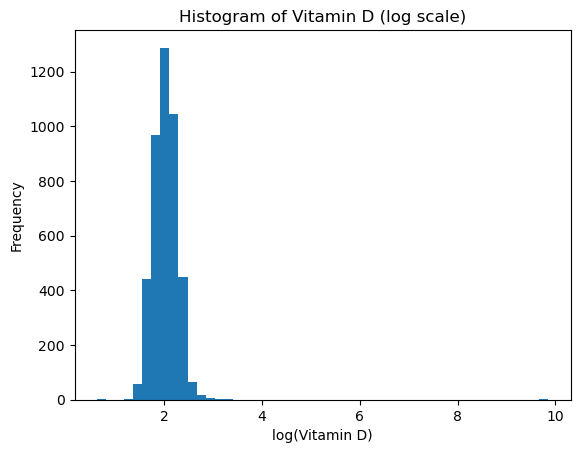

In [71]:
import numpy as np
log_values = np.log(nutrient_ratio["Vitamin D"].values + 1)  # +1 to avoid log(0)
plt.hist(log_values, bins=50)
plt.xlabel("log(Vitamin D)")
plt.ylabel("Frequency")
plt.title("Histogram of Vitamin D (log scale)")
plt.show()

In [72]:
print(nutrient_ratio['Vitamin D'].describe())

count     4350.000000
mean        11.126904
std        288.304011
min          0.874681
25%          5.396574
50%          6.545526
75%          7.846483
max      19021.301922
Name: Vitamin D, dtype: float64


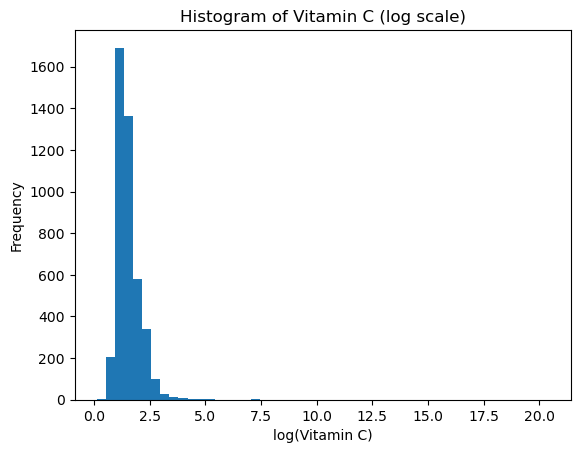

In [73]:
import numpy as np
log_values = np.log(nutrient_ratio["Vitamin C"].values + 1)  # +1 to avoid log(0)
plt.hist(log_values, bins=50)
plt.xlabel("log(Vitamin C)")
plt.ylabel("Frequency")
plt.title("Histogram of Vitamin C (log scale)")
plt.show()

In [74]:
print(nutrient_ratio['Vitamin C'].describe())

count    4.350000e+03
mean     1.657750e+05
std      1.093305e+07
min      1.565053e-01
25%      2.344118e+00
50%      3.132772e+00
75%      4.845194e+00
max      7.210843e+08
Name: Vitamin C, dtype: float64


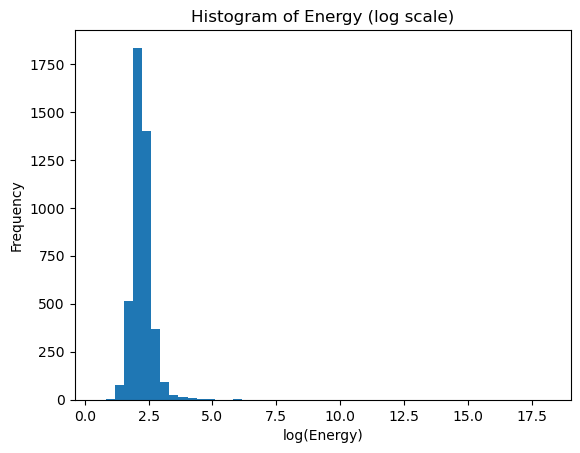

In [75]:
import numpy as np
log_values = np.log(nutrient_ratio["Energy"].values + 1)  # +1 to avoid log(0)
plt.hist(log_values, bins=50)
plt.xlabel("log(Energy)")
plt.ylabel("Frequency")
plt.title("Histogram of Energy (log scale)")
plt.show()

In [76]:
print(nutrient_ratio['Energy'].describe())

count    4.350000e+03
mean     1.756657e+04
std      1.157936e+06
min      6.325285e-01
25%      6.543455e+00
50%      8.090076e+00
75%      1.032514e+01
max      7.637110e+07
Name: Energy, dtype: float64


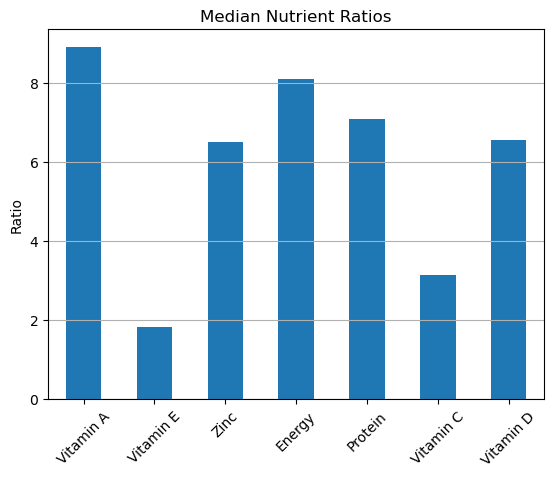

In [86]:
import matplotlib.pyplot as plt

selected_nutrients = ['Vitamin A', 'Vitamin E', 'Zinc', 'Energy', 'Protein', 'Vitamin C', 'Vitamin D']
nutrient_means = nutrient_ratio[nutrient_ratio[selected_nutrients] != 0][selected_nutrients].median()
nutrient_means.plot(kind='bar')
plt.title('Median Nutrient Ratios')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout
plt.show()